# Test Step conditional imputing

In [1]:
import sys


import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#1. load environment variables and data

# load environment variables
load_dotenv()

#add working directory to sys path to execute utils/dataset.py
working_dir = os.environ.get("WORKING_DIRECTORY")
sys.path.insert(0, working_dir)

from utils.dataset import get_data 

from utils.pipeline_moduls import fs_colinearity, fs_vif, outlier_label, dim_reduction

df = get_data()


df.head(10)


Loading data from wines: 8000it [00:00, 21501.74it/s]


,wine type,fixed acidity,volatile acidity,citric acid,residual sugar,magnesium,flavanoids,minerals,calcium,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,Pinot noir,5.8,0.15,0.49,1.1,76.729301,894.94,186.639301,109.91,0.048,21.0,98.0,0.99290,3.19,0.48,9.2,5
1,Merlot,6.6,0.25,0.32,5.6,4.795712,1160.95,251.875712,247.08,0.039,15.0,68.0,0.99163,2.96,0.52,11.1,6
2,Chardonnay,6.7,0.21,0.34,1.5,85.193710,789.82,304.703710,219.51,0.035,45.0,123.0,0.98949,3.24,0.36,12.6,7
3,Merlot,8.3,0.28,0.27,17.5,11.976525,777.86,237.586525,225.61,0.045,48.0,253.0,1.00014,3.02,0.56,9.1,6
4,Merlot,7.5,0.42,0.19,6.9,5.599673,785.72,95.399673,89.80,0.041,62.0,150.0,0.99508,3.23,0.37,10.0,6
5,Merlot,7.3,0.34,0.30,1.3,22.403749,1044.95,289.523749,267.12,0.057,25.0,173.0,0.99480,3.26,0.51,9.1,6
6,Merlot,7.6,0.21,0.49,2.5,23.875866,888.61,133.545866,109.67,0.047,20.0,130.0,0.99178,3.15,0.48,11.1,5
7,Chardonnay,6.0,0.25,0.40,5.7,23.309699,1381.79,266.529699,243.22,0.052,56.0,152.0,0.99398,3.16,0.88,10.5,6
8,Cabernet Sauvignon,6.7,0.18,0.19,4.7,49.165745,1456.41,269.915745,220.75,0.046,57.0,161.0,0.99460,3.32,0.66,10.5,6
9,Gamay,7.7,0.28,0.39,8.9,54.450579,929.44,377.690579,323.24,0.036,8.0,117.0,0.99350,3.06,0.38,12.0,2


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

In [9]:
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import kstest, uniform
from sklearn.impute import KNNImputer
def outlier_num(df, strategy='median', model=None):
    """This function detects outliers in the dataframe and imputes them with the median.
    :param df: dataframe with only numerical features
    :param strategy: choose median, mean  most_frequent method. Defaul = median
    """
    #detect outliers and impute them with the simple imputer
    #detect outliers
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    not_normalized_columns = []
    #detect outliers for each column and set them to NaN
    for col in df.columns:
        df.loc[(df[col] < (Q1[col] - 1.5 * IQR[col])) | (df[col] > (Q3[col] + 1.5 * IQR[col])), col] = np.nan

        #check if column is normal distributed and then impute
        p_value_uniform_distribution = kstest(df[col], 'uniform').pvalue
        #impute column with KNNImputer
    imputer = KNNImputer(n_neighbors=7)
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


        # if p_value_uniform_distribution < 0.05:
        #         print(col, "is uniformly distributed")
        #         df[col] = df[col].fillna(df[col].median())
        #         not_normalized_columns.append(col)

        # elif df[col].skew() > 0.5 or df[col].skew() < -0.5:
        #     print(col, "is not normal distributed")
        #     df[col] = df[col].fillna(df[col].median())
        #     not_normalized_columns.append(col)
            
        # else:
        #     print(col, "is normal distributed")
        #     df[col] = df[col].fillna(df[col].mean())

    # print("not normalized columns", not_normalized_columns)
    # if model in ["LinearRegression"]:
    #     print(model, "in ['LinearRegression']")
    #     #make normal distribution in all columns with quantile transformation
    #     # for col in not_normalized_columns:
    #     #     df[col] = QuantileTransformer(output_distribution='normal').fit_transform(df[col].values.reshape(-1,1))
    # else:
    #     pass
    #show me the distribution of each column besides its 3rd standard deviation in one figure
    fig, axes = plt.subplots(6, 3, figsize=(20, 20))
    for i, column in enumerate(df.select_dtypes(exclude='object').columns):
        mean = df[column].mean()
        std = df[column].std()
        sns.histplot(data=df, x=column, ax=axes[i//3][i%3])
        axes[i//3][i%3].axvline(mean + 3*std, color='r', linestyle='--')
        axes[i//3][i%3].axvline(mean - 3*std, color='r', linestyle='--')
    plt.show()
    return df

In [10]:
import json

def feature_selection(df,colinearity_threshold=0.5, correlation_threshold=0.1, vif_threshold=5):
    dropped_features = []
    dropped_features_set = set(dropped_features)

    # Add elements from fs_colinearity to dropped_features_set
    dropped_features_set.update(fs_colinearity(df, colinearity_threshold, correlation_threshold))

    # Add elements from fs_vif to dropped_features_set
    dropped_features_set.update(fs_vif(df, correlation_threshold, vif_threshold))

    # Convert dropped_features_set back to a list
    dropped_features = list(dropped_features_set)
    print("Dropping Features: ", dropped_features)
    # Drop the features in dropped_features from the DataFrame
    df = df.drop(columns=dropped_features)

    # Save dropped features list to a JSON file
    if df.shape[0] > 7000:
        with open('dropped_features.json', 'w') as f:
            json.dump(dropped_features, f)
    else:
        with open('./models/7000_samples/dropped_features.json', 'w') as f:
            json.dump(dropped_features, f)

    return df
feature_selection = FunctionTransformer(feature_selection).set_output(transform="pandas")

/opt/anaconda3/envs/data-science/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [11]:
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=[np.number]).columns
#drop 'quality' from numerical features (its a series)
numerical_features = numerical_features.drop('quality')
label = pd.Series('quality')
outlier_detection_label = FunctionTransformer(outlier_label).set_output(transform="pandas")
outlier_detection = FunctionTransformer(outlier_num).set_output(transform="pandas")

/opt/anaconda3/envs/data-science/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [12]:
cleaning_pipeline = Pipeline(steps=[
])
categorical_imputer = SimpleImputer(strategy="most_frequent").set_output(transform="pandas")

#pipeline for categorical features
categorical_pipeline = Pipeline(steps=[])
categorical_pipeline.steps.append(('imputer', categorical_imputer))
categorical_pipeline.steps.append(('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform="pandas")))
#pipeline for numerical features
numeric_pipeline = Pipeline(steps=[])
numerical_imputer = SimpleImputer(strategy="mean").set_output(transform="pandas")

numeric_pipeline.steps.append(('imputer', numerical_imputer))
numeric_pipeline.steps.append(('outlier_detection', outlier_detection))
#pipeline for label
label_pipeline = Pipeline(steps=[])
#generate pass through function
pass_through = FunctionTransformer().set_output(transform="pandas")
label_pipeline.steps.append(('do_nothing', pass_through))
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
        ('label', label_pipeline, label)
    ]).set_output(transform="pandas")
cleaning_pipeline.steps.append(('preprocessor', preprocessor))
cleaning_pipeline.steps.append(("outlier_detection_label", outlier_detection_label))
cleaning_pipeline.steps.append(('feature_selection', feature_selection))
cleaning_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outlier_detection',
                                                                   FunctionTransformer(func=<function outlier_num at 0x132c88a40>))]),
                                                  Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'magnesium', 'flavanoids', 'minerals', 'calcium', 'chlorides',
       'free sulfur dioxide', 'to...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['wine type'], dtype='object')),
                                                 ('label',
                                                  Pipeline(steps=[('do_nothing',
                                                                   FunctionTransformer())]),
                                                  0    quality
dtype: object)])),
                ('outlier_detection_label',
                 FunctionTransformer(func=<function outlier_label at 0x12e6c8f40>)),
                ('feature_selection',
                 FunctionTransformer(func=<function feature_selection at 0x132c898a0>))])

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

models = [
    {
        "name": "LinearRegression",
        "estimator": LinearRegression(),
        "hyperparameters":
            {
                "fit_intercept": [True, False],
                "copy_X": [True, False]
            },
        "scalable": 0
    },
    {
        "name": "DecisionTreeRegressor",
        "estimator": DecisionTreeRegressor(),
        "hyperparameters":
            {
                "criterion": ["squared_error", "friedman_mse"],
                "splitter": ["best", "random"],
                "max_depth": [None, 2, 5, 10],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 5, 10]
            },
        "scalable": 0
    }
]


LinearRegression
----------------


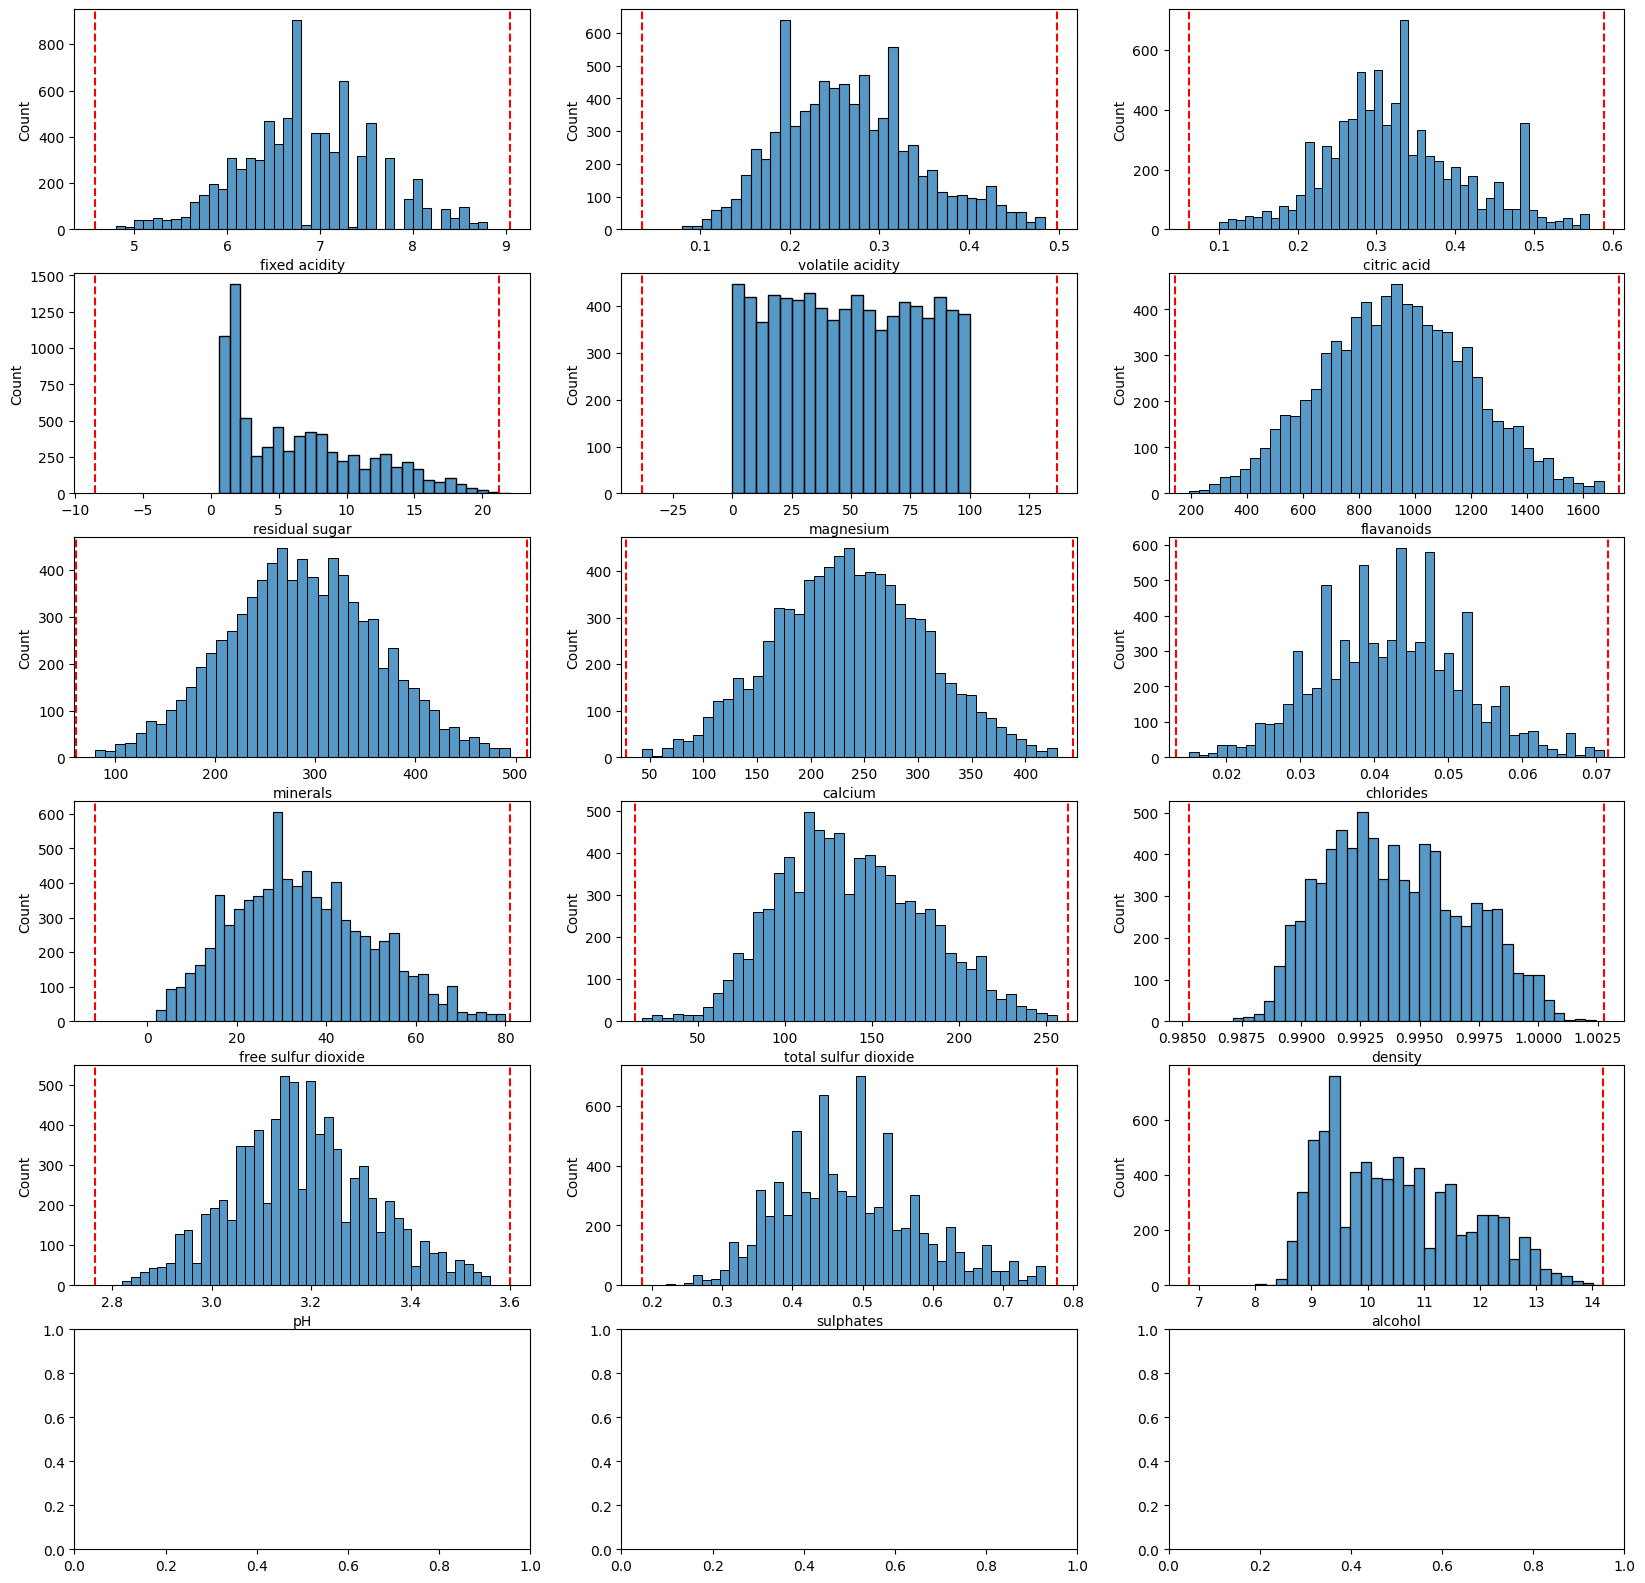

/opt/anaconda3/envs/data-science/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping Features:  ['cat__wine type_Pinot noir', 'num__calcium', 'num__free sulfur dioxide', 'num__residual sugar', 'num__minerals']
Best Parameters:
{'copy_X': True, 'fit_intercept': True}

Best Score: 0.535592410081394 	 Test Score: 0.5354840841214571
Fit Time: 0.003857135772705078

DecisionTreeRegressor
---------------------


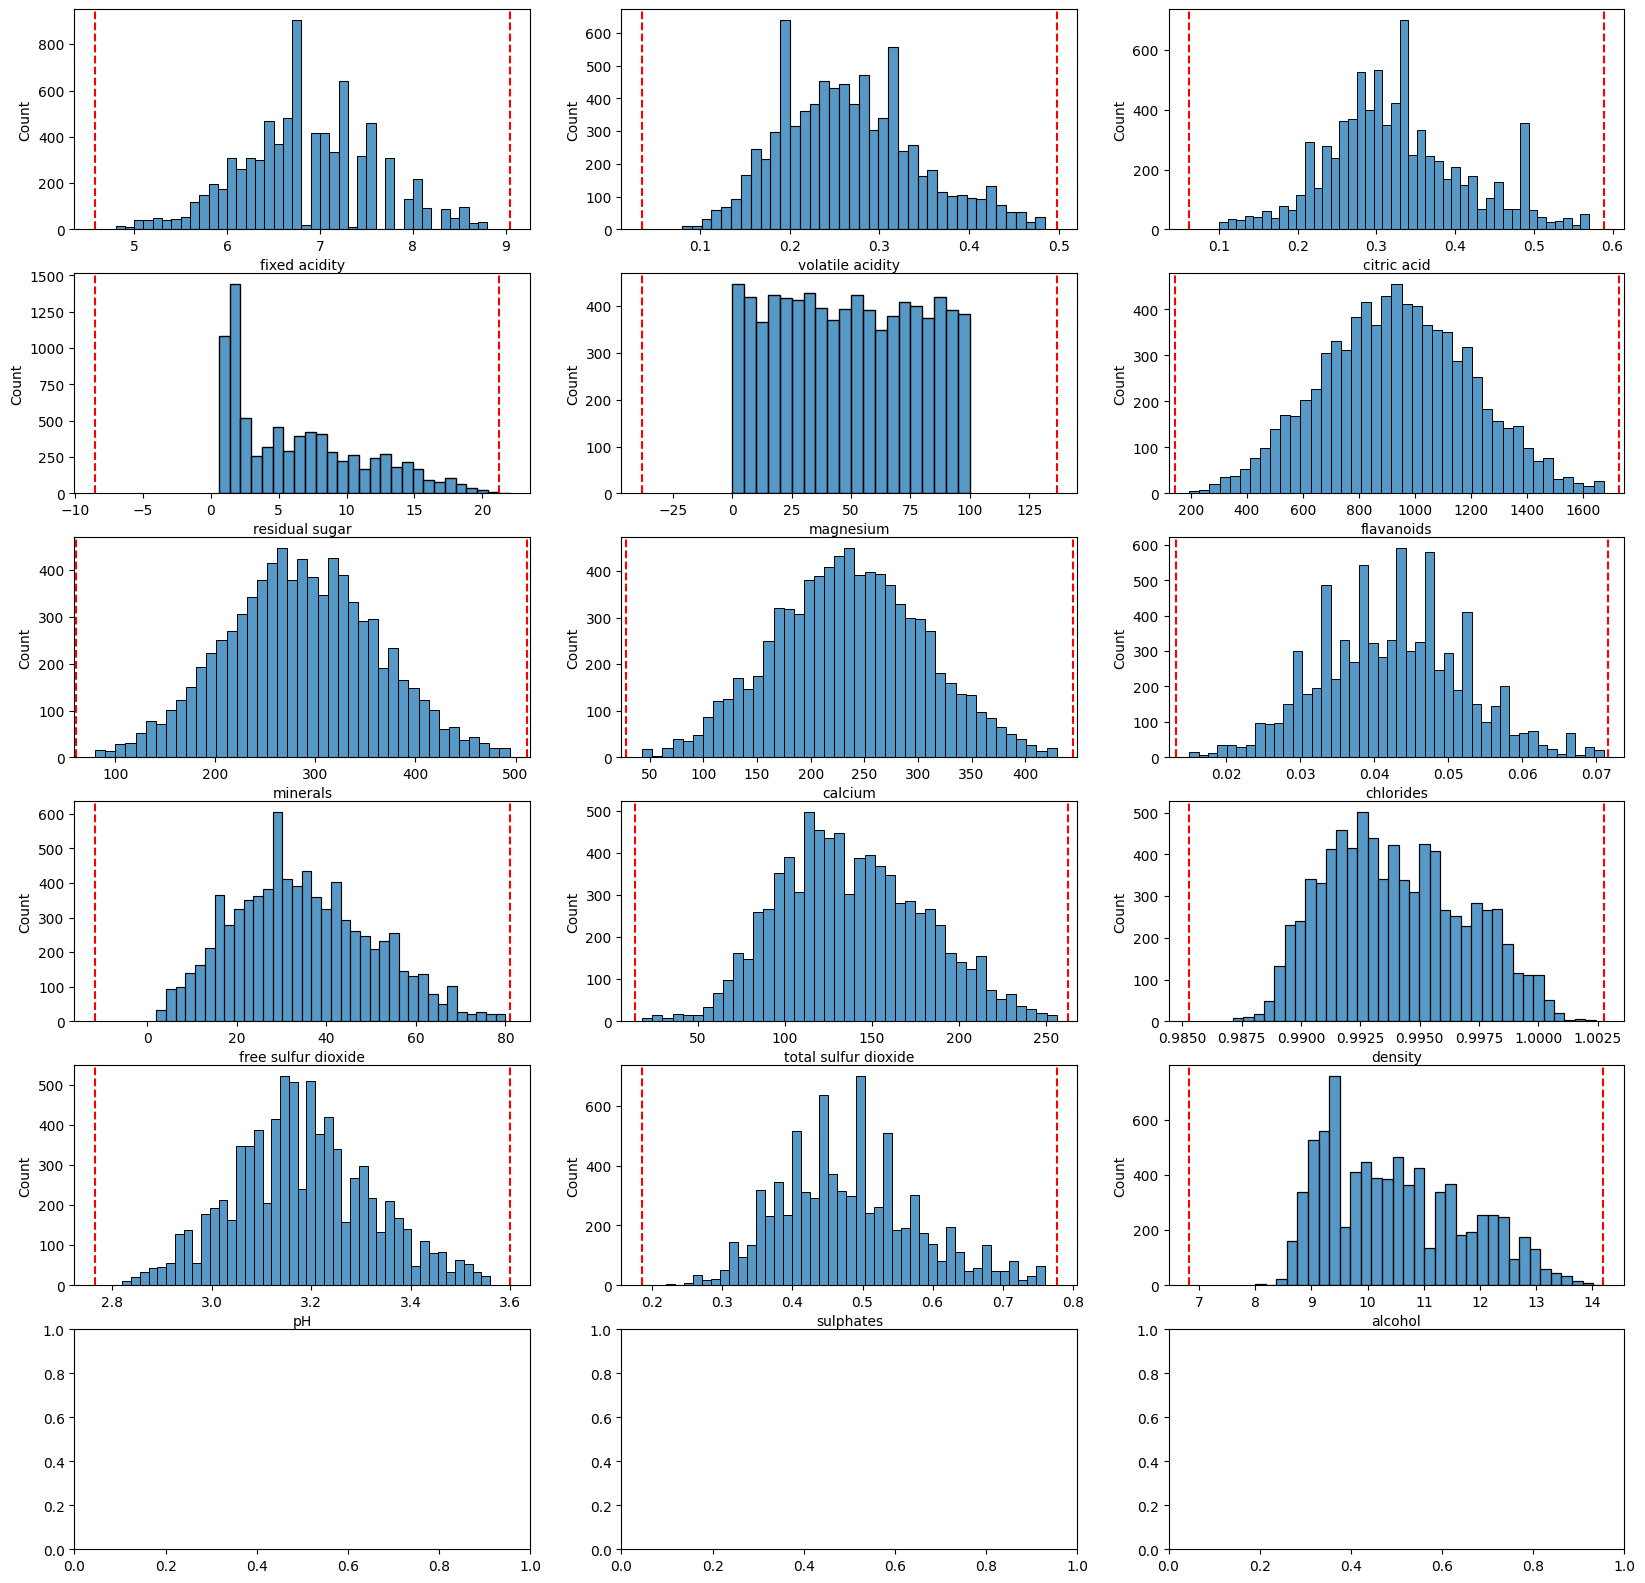

/opt/anaconda3/envs/data-science/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping Features:  ['cat__wine type_Pinot noir', 'num__calcium', 'num__free sulfur dioxide', 'num__residual sugar', 'num__minerals']
Best Parameters:
{'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}

Best Score: 0.7968272076967239 	 Test Score: 0.8697223591260063
Fit Time: 0.08314681053161621



In [14]:
best_models = []
for model in models:
    print(model["name"])
    print("-"*len(model["name"]))
    if model["scalable"] is not None:
        if model["scalable"] == 0:
            preprocessor = cleaning_pipeline.steps[0][1]
            if model["name"] == "LinearRegression":
                preprocessor.transformers[0][1].steps[1][1].set_params(kw_args={"model": model["name"]})
            else:
                preprocessor.transformers[0][1].steps[1][1].set_params(kw_args={"model": None})
            clean_df = pd.DataFrame(cleaning_pipeline.fit_transform(df))
        if model["scalable"] == 1:
            #clean_df = pd.DataFrame(cleaning_pipeline_scaled.fit_transform(dirty_df))
            pass
    X = clean_df.drop('label__quality', axis=1)
    y = clean_df['label__quality']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    grid = GridSearchCV(model["estimator"], model["hyperparameters"], cv=10, n_jobs=-1)
    grid = grid.fit(X_train, y_train)
    print("Best Parameters:")
    print(grid.best_params_)
    print("")
    print("Best Score:", grid.best_score_, "\t", "Test Score:", grid.score(X_test, y_test))
    print("Fit Time:", grid.refit_time_)
    print("")
    m = {
        "name": model["name"],
        "best_params": grid.best_params_,
        "best_score": grid.best_score_,
        "fit_time": grid.refit_time_,
        "test_score":  grid.score(X_test, y_test)
    }
    best_models.append(m)
        